# Maximisation de la rentabilité d'une installation de stockage

Le but de ce notebook est de déterminer une fonction qui estime la rentabilité d'une installation de stockage supplémentaire, afin de pouvoir ensuite la minimiser. 
La question à laquelle on souhaite répondre est : **quelle est l'installation de stockage supplémentaire en terme de capacité qui est la plus rentable ?**

Cette fonction qui calcule la rentabilité se basera sur une évaluation des *coûts de production évités* annuellement grâce à cette installation supplémentaire de stockage, et *aux coûts CAPEX+OPEX* annualisé de cette installation supplémentaire.
Elle sera ensuite maximiser à l'aide de *Processus Gaussiens*, l'idée étant de minimiser le nombre d'appel à cette fonction très coûteuse.

## Importer les données annuelles de la PPE

Nous nous baserons uniquement sur les données de l'année 2017 por l'évaluation des coûts de production annuels (avec comme référence les capacités et puissance utilisées dans le premier TP sur la Réunion).

*Note* : en deuxième lecture on pourra envisager de réaliser cette estimation de coûts de productions annuels sur plusieurs années de données ou sur des données générées pour plus de diversité et de robustesse.

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_excel("historic_data.xlsx")
data = data.drop(["Unnamed: 8", "moyen à considérer comme"], axis=1).set_index("Date")

In [4]:
data.head()

,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
Date,,,,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
2017-01-01 05:00:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2017-01-01 06:00:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
2017-01-01 07:00:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
2017-01-01 08:00:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [5]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

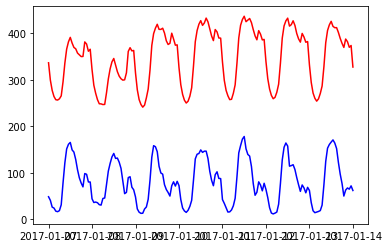

In [6]:
week = data.loc["2017-01-07 00:00":"2017-01-14 00:00"]
demand = week["Consommation (MW)"]
plt.plot(demand, "r")
prod_fatale = week["Fatal (MW)"]
plt.plot(prod_fatale, "b")

costs = np.array([20, 40])
power_max = np.array([400, 200])
power_min = np.array([50, 20])

Pour l'évaluation des coûts de production annuels, nous réutilisons le code développé au premier TP du module DETE305 avec une optimisation du coût de production en utilisant le stockage sur une période d'une semaine. Nous itérons donc ce calcul sur chaque semaine de l'année, en prenant l'hypothèse (vérifiée a fortiori) d'un épuisement complet de la batterie entre chaque semaine. Ceci permettrait notamment de paralléliser ces calculs d'optimisation hebdomadaire.

## La modélisation du problème de rentabilité

Nous définissons d'abord une colonne FATAL représentant les énergies non dispatchables, incluant l'hydraulique qui pour le moment sera considéré comme 100% fatal. 

In [7]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

In [8]:
df = data.copy()
df.columns = [
    "Consommation",
    "Thermique",
    "Bagasse",
    "Hydraulique",
    "PV",
    "Eolien",
    "Bioenergies",
    "FATAL",
]
df = df.drop(["Hydraulique", "PV", "Eolien", "Bioenergies"], axis=1)

On va alors optimiser la répartition de la production entre thermique, bagasse/charbon et stockage sur des durée d'une semaine. Pour cela nous aurons besoin des capacités de stockage - on considère dans un premier temps qu'il n'y a pas de contrainte sur la puissance de charge et décharge du stockage autre qu'une majoration de puissance max, nous expliquerons pourquoi plus loin. Nous aurons aussi besoin des capacités de production du thermique et de la bagasse/charbon, ainsi que leurs contraintes de temps d'arrêt et le coût de production associé.
Les données ci-dessous sont extraites de la PPE (hors valeurs de stockage qui seront modifiées dans les appels de fonction).

In [81]:
pmin_ther, pmax_ther = 60, 351  # MW
pmin_char, pmax_char = 100, 210  # MW
cost_ther = 387.9  # €/MWh
cost_char = 133.8  # €/MWh
cost_fioul = 186.4  # €/MWh
# Modifiees
capa_stock = 0  # Set to 0 later
pmax_stock = 100

Cette optimisation par semaine sur l'année nous retournera le coût de production sur l'année 2017.

Dans un deuxième temps nous aurons besoin d'une évaluation du coût fixe annuel de cette capacité de stockage supplémentaire installée, pour faire un rapport entre le coût évité par une nouvelle installation et ce coût fixe annuel. Il devra prendre en compte notamment le CAPEX répartit sur une durée de vie estimée et l'OPEX associée. 
Nous ne prenons pas en compte l'utilisation du stockage dans l'année sur cette évaluation du coût fixe, alors que cette utilisation peut avoir une grande importance sur la durée de vie (par exemple pour une batterie mal utilisée), mais construire ce modèle serait trop complexe ici, nous en reparlerons dans la dernière partie.

## Rentabilité d'une installation de stockage

On reprend ici le premier TP DETE305 légèrement modifié.

In [10]:
import pulp

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Récupération d'une semaine
week = df.loc["2017-01-01":"2017-01-07"]
week

,Consommation,Thermique,Bagasse,FATAL
Date,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,30.043
2017-01-01 05:00:00,251.673,30.472,194.092,27.109
2017-01-01 06:00:00,242.021,30.010,181.286,30.725
2017-01-01 07:00:00,233.028,24.341,173.220,35.466
2017-01-01 08:00:00,245.900,14.836,163.957,67.107
...,...,...,...,...
2017-01-07 19:00:00,350.045,92.799,186.517,69.846
2017-01-07 20:00:00,381.292,95.241,186.704,98.462
2017-01-07 21:00:00,376.769,92.802,186.232,96.850


In [57]:
def solve_week(week, **kwargs):
    # Set modified arguments if presents
    pmin_ther = kwargs["pmin_ther"] if "pmin_ther" in kwargs.keys() else 10
    pmax_ther = kwargs["pmax_ther"] if "pmax_ther" in kwargs.keys() else 300
    pmin_char = kwargs["pmin_char"] if "pmin_char" in kwargs.keys() else 150
    pmax_char = kwargs["pmax_cahr"] if "pmax_char" in kwargs.keys() else 1100
    capa_stock = kwargs["capa_stock"] if "capa_stock" in kwargs.keys() else 0
    pmax_stock = (
        kwargs["pmax_stock"] if "pmax_stock" in kwargs.keys() else capa_stock / 5
    )
    cost_ther = kwargs["cost_ther"] if "cost_ther" in kwargs.keys() else 300
    cost_char = kwargs["cost_char"] if "cost_char" in kwargs.keys() else 150

    df = week.copy()
    tprob = pulp.LpProblem("Week", pulp.LpMinimize)
    demand = list(week["Consommation"])
    fatal = list(week["FATAL"])
    nbsteps = week.shape[0]
    ## production
    p_ther = [pulp.LpVariable(f"p_ther_{t}", 0, pmax_ther) for t in range(0, nbsteps)]
    p_char = [pulp.LpVariable(f"p_char_{t}", 0, pmax_char) for t in range(0, nbsteps)]
    p_load = [pulp.LpVariable(f"p_load_{t}", 0, pmax_stock) for t in range(0, nbsteps)]
    stock = [pulp.LpVariable(f"stock_{t}", 0, capa_stock) for t in range(0, nbsteps)]

    ## on/off
    on_ther = [
        pulp.LpVariable(f"on_ther_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_char = [
        pulp.LpVariable(f"on_char_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_load = [
        pulp.LpVariable(f"on_load_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]

    # constraints
    for t in range(0, nbsteps):
        tprob += p_ther[t] >= pmin_ther * on_ther[t]  # if 'on' produce at least min
        tprob += (
            p_ther[t] <= pmax_ther * on_ther[t]
        )  # if 'on' produce at most max, if 'off' produce 0
        tprob += p_char[t] >= pmin_char * on_char[t]
        tprob += p_char[t] <= pmax_char * on_char[t]
        tprob += p_load[t] >= 0 * on_load[t]
        tprob += p_load[t] <= pmax_stock * on_load[t]

        tprob += p_load[t] <= stock[t - 1]
        tprob += p_ther[t] + p_char[t] + fatal[t] + p_load[t] >= demand[t]

    for t in range(1, nbsteps):
        tprob += stock[t] == stock[t - 1] - p_load[t - 1] + (
            p_load[t - 1] + p_ther[t - 1] + p_char[t - 1] + fatal[t - 1] - demand[t - 1]
        )

    # objective
    tprob += sum(
        [p_ther[t] * cost_ther + p_char[t] * cost_char for t in range(0, nbsteps)]
    )
    tprob.solve()
    df["Pred_thermique"] = [pulp.value(p_ther[t]) for t in range(0, nbsteps)]
    df["Pred_charbon"] = [pulp.value(p_char[t]) for t in range(0, nbsteps)]
    df["Puissance_stock"] = [pulp.value(p_load[t]) for t in range(0, nbsteps)]
    df["Stockage"] = [pulp.value(stock[t]) for t in range(0, nbsteps)]

    return df

In [58]:
result = solve_week(week, capa_stock=0)

In [59]:
def plot_week(week):
    week.plot(
        y=["Consommation", "Pred_thermique", "Pred_charbon", "Puissance_stock", "FATAL"]
    )

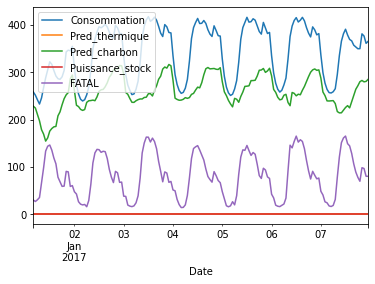

In [60]:
plot_week(result)

Rappel : ce que nous cherchons dans cette partie est le coût annuel de production nécessaire optimisé grâce au stockage d'énergie, un coût en euro donc qui devra être comparé au coût de production (pour la même année) utilisant l'installation de stockage d'énergie actuellement présente à la Réunion (le scénario réel).

Pour cela définissons déjà le scénario réel : les coûts de production et capacités ont été reprises du premier TP sur la PPE (Excel). L'installation de stockage actuelle est estimée à 550 MWh. La puissance de charge maximale ou nominale quant à elle inconnue. Nous prendrons l'hypothèse d'une puissance maximale de charge (et décharge) de 100MW sur l'ensemble des installations. 
Cette hypothèse se base sur le ratio courant entre puissance nominale et capacité de batterie, multiplié par la capacité installée. 

**Note sur le modèle de stockage**
Nous pouvons voir les installations de stockage comme une énorme batterie avec des cellules indépendantes et que nous gérons de façon à ce que la puissace de charge ou décharge totale respecte la puissance nominale de chaque cellule (en chargeant certaines, déchargeant d'autres et laissant le reste de côté). C'est un principe utilisé dans les EMS des home-batteries par exemple dans les batteries Tesla.

In [61]:
# calculer le coût pour l'année 2017 avec les valeurs normales
print("Production thermique (MW): ", {np.sum(result["Pred_thermique"])})
print("Production charbon (MW): ", {np.sum(result["Pred_charbon"])})
print(
    np.sum(result["Pred_thermique"]) * cost_ther
    + np.sum(result["Pred_charbon"]) * cost_char
)
reference_cost = (
    np.sum(result["Pred_thermique"]) * cost_ther
    + np.sum(result["Pred_charbon"]) * cost_char
)

Production thermique (MW):  {0.0}
Production charbon (MW):  {42426.37500000001}
5676648.9750000015


In [62]:
def annual_cost(stockage, **kwargs):
    cost_ther = kwargs["cost_ther"] if "cost_ther" in kwargs.keys() else 397.9
    cost_char = kwargs["cost_char"] if "cost_char" in kwargs.keys() else 133.8
    costs = 0
    for date in range(0, 8760, 168):
        week = df.iloc[date : (date + 168)]
        result = solve_week(week, capa_stock=stockage, **kwargs)
        cost = (
            np.sum(result["Pred_thermique"]) * cost_ther
            + np.sum(result["Pred_charbon"]) * cost_char
        )
        costs += cost
    return costs

In [63]:
reference = annual_cost(0)
reference

306052318.0799

Nous trouvons avec ceci un coût annuel de production de 337,419 M€ pour cette année 2017.

**Attention** : dès que nous modifierons des paramètres (puissances, capacités, consommation), nous devrons recalculer cette donnée de référence. 

### Coût fixe des installations

Face à ces coûts de production évités, on estime ce que coûte annuellement la capacité de stockage supplémentaire installée. Pour cela on va s'intéresser uniquement à trois modes de stockage grande capacité : les batteries Li-ion, les volants d'inertie, et les STEPs. Pour chacun une recherche des ordres de grandeurs nous permet d'estimer le coût fixe annualisé d'une installation (CAPEX + OPEX) pour chaque mode de stockage. Ces valeurs sont biensûr grossières, et dépendent fortement du projet et des caractéristiques locales (réseau local de distribution, main d'œuvre, etc...). Nous le rappelons, l'objectif de ce notebook n'est pas de donner un chiffre d'installation de stockage le plus pertinent, mais de donner une méthode d'optimisation qui sera facilement affinée en précision.

On trouve grâce à ces recherches que le coût fixe annualisé du volant d'inertie est de 280,01 €/kW-an. Ceci correspond donc à un coût par puissance installée. Ce qui nous intéresse dans notre cas est le coût par capacité installée, pour cela nous aurons également besoin d'un chiffre moyen de conversion (un volant a un temps caractéristique de 0.25 heures de stockage en moyenne).
Nous pourrons ainsi régler la valeur de `pmax_stock` en même temps que la valeur de `cap_stock`.

In [19]:
annual_cost_inert_pp = 280.01  # pp for per power installed kW
annual_cost_bat_pp = 158.95
annual_cost_step_pp = 301.81
annual_cost_inert_pc = 1119.97e3  # pc for per capacity installed MWh
annual_cost_bat_pc = 52.76e3
annual_cost_step_pc = 18.91e3

Enfin il ne reste plus qu'à implémenter notre fonction globale à optimiser : la fonction qui à partir d'une capacité de stockage supplémentaire installée retourne la rentabilité annuelle de l'installation (coûts évités - coûts fixes).

In [64]:
def rentability(
    installed_capa, initial_capa=0, reference_cost=reference
):  # change reference cost if needed
    avoided_costs = -annual_cost(initial_capa + installed_capa) + reference_cost
    print(f"Avoided costs for {installed_capa}MWh more : {avoided_costs}€/an")
    fixed_costs = (
        annual_cost_bat_pc * installed_capa
    )  # based on full batteries installation
    return avoided_costs - fixed_costs

In [28]:
rentability(500, reference)

-16969079.31799996

In [54]:
rentability(2)

Avoided costs for 2MWh more : 100448.0218000412€/an


-5071.978199958801

Ici on note une rentabilité positive de 115 k€ annuelle pour une installation supplémentaire de 5MW de batteries. En réalité la rentabilité est négative : le coût de production de référence est arrondi au M€ et donc 419k€ manquent à l'appel. Ce n'est pas très important pour la suite puisque nous allons simplement chercher à maximiser cette fonction sans nous occuper des valeurs absolues.

## Optimisation de l'installation de stockage

À partir de cette fonction qui modélise la rentabilité d'une installation de stockage selon la capacité installée, nous cherchons à trouver l'installation (en terme de capacité) qui maximise la rentabilité.
Puisque chaque appel à notre fonction demande beaucoup de ressources (en temps de calcul et énergie), nous voulons réaliser cette optimisation en limitant le nombre d'appel à la fonction. De plus, cette fonction est considérée comme une boîte noire, nous ne pouvons en tirer de gradient et nous ne savons a priori pas comment elle se comporte.

*Note :* la fonction ici ne coûte en réalité pas excessivement cher, mais puisque plus tard cette évaluation de la rentabilité pourra prendre compte de l'évolution du parc de production, du mode d'utilisation du stockage sur le coût opérationnel, la fonction sera en réalité effectivement gourmande en ressources.

<div class="alert alert-success">
    
**Pour réaliser cette optimisation nous utiliserons des Processus Gaussiens:**
L'hypothèse mathématique sur laquelle se basent le Processus Gaussien est que notre fonction est en quelque sorte régulière, et que chaque point est proche des points adjacents. Ainsi à partir de points connus et en suivant une hypothèse de régularité et de distribution (qui sort du cadre de ce notebook) nous pouvons estimer la fonction réelle avec un modèle et la valeur de tous les autres points en moyenne et en écart-type.
  
Un exemple de processus Gaussien est donné juste en dessous pour estimer une fonction `fun` de forme sinusoïdale à partir de seulement 3 points.
Le code est inspiré d'un notebook sur les Processus Gaussiens pour la réalisation de Surrogate Models.
</div>

In [29]:
def fun(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))


X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# The gaussian process is based on a kernel which embed our prior assumptions on the function
kernel_local = RBF()
gp = GaussianProcessRegressor(kernel=kernel_local)

x_data = np.atleast_2d([0, 5, 25]).T
y_data = fun(x_data)
gp.fit(x_data, y_data)
# print("score : ", gp.score(x_data, y_data))
print("hyperparameters : ", gp.kernel_.theta)

hyperparameters :  [0.00020173]


In [31]:
from smt.surrogate_models import KRG

gpr = KRG(theta0=[1e-2] * x_data.shape[1], print_prediction=False)
gpr.set_training_values(x_data, y_data)

gpr.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0221961


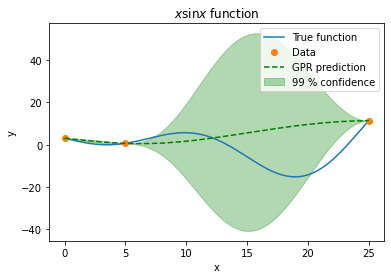

In [32]:
Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_plot = gpr.predict_variances(X_plot)

fig = plt.figure()
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(data,) = ax.plot(x_data, y_data, linestyle="", marker="o")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.atleast_2d(sig_GP_plot)
sig_moins = Y_GP_plot - 3 * np.atleast_2d(sig_GP_plot)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, data, gp, un_gp]
ax.set_title("$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "Data", "GPR prediction", "99 % confidence"])
plt.show()

Sur ce principe nous allons pouvoir itérer en choisissant un prochain point d'exploration qui sera potentiellement supérieur au maximum actuel en prenant en compte l'écart-type de la régression par le Processus Gaussien. Ainsi pour l'exemple précédent le prochain point pourrait être en 15.
Nous définissons pour cela une fonction *Expected Improvement* qui va justement nous permettre de choisir ce prochain x à explorer.

In [33]:
from scipy.stats import norm
from scipy.optimize import minimize

# Expected Improvement function
def EI(GP, points, f_min):
    pred_mu = GP.predict_values(points)
    pred_sig = GP.predict_variances(points)
    args0 = (f_min - pred_mu) / np.atleast_2d(pred_sig)
    args1 = (f_min - pred_mu) * norm.cdf(args0)
    args2 = np.atleast_2d(pred_sig) * norm.pdf(args0)
    ei = args1 + args2
    return ei.ravel()

Pour notre exemple nous réduisons notre fenêtre d'installation à 100MW supplémentaires. Libre à vous de modifier cette valeur dans `X_plot` et `boundaries` ci-dessous.

In [69]:
X_plot = np.atleast_2d(np.linspace(0, 1000, 10000)).T


def EGO(n_iter, x_data, y_data, fun, boundaries=(0, 100)):
    for k in range(n_iter):

        # model
        GP = KRG(
            theta0=[1e-2] * x_data.shape[1], print_prediction=False, print_global=False
        )
        GP.set_training_values(x_data, y_data)
        GP.train()

        # fmin
        f_min = np.min(y_data)

        # find x arg max EI
        obj_EI = lambda x: -EI(GP, np.atleast_2d(x), f_min)
        # different starting for non local max
        x_start = np.random.rand(15) * boundaries[1]
        opt_all = np.array(
            [
                minimize(
                    obj_EI, x_st, method="SLSQP", bounds=[boundaries]
                )  # modify boundaries
                for x_st in x_start
            ]
        )
        opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
        if len(opt_success) == 0:
            print("No success solution in minimize EI")
            x_opt = x_data[0]
        else:
            obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
            ind_min = np.argmin(obj_success)
            opt = opt_success[ind_min]
            x_opt = opt["x"]

        if x_opt in x_data:
            x_opt = np.random.rand() * boundaries[1]
        # evaluation
        y_opt = fun(x_opt)
        print("New value in : ", x_opt)

        # concat
        y_data = np.atleast_2d(np.append(y_data, y_opt)).T
        x_data = np.atleast_2d(np.append(x_data, x_opt)).T

        Y_GP_plot = GP.predict_values(X_plot)
        sig_GP_Plot = GP.predict_variances(X_plot)
        Y_EI_plot = EI(GP, X_plot, np.min(y_data))

        fig = plt.figure()
        ax = fig.add_subplot(111)
        (data,) = ax.plot(x_data, y_data, linestyle="", marker="o")
        (gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
        sig_plus = Y_GP_plot + 3 * np.atleast_2d(sig_GP_Plot)
        sig_moins = Y_GP_plot - 3 * np.atleast_2d(sig_GP_Plot)
        ax1 = ax.twinx()
        un_gp = ax1.fill_between(
            X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        (ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
        lines = [data, gp, un_gp, ei]
        ax.set_title("Non-Rentability function (-rentability to minimize)")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend(lines, ["Data", "GPR prediction", "99 % confidence", "EI"])
        plt.show()
    ind_best = np.argmin(y_data)
    x_opt = x_data[ind_best]
    y_opt = y_data[ind_best]
    return x_opt, y_opt, x_data, y_data

**N.B.** ce code minimise la fonction en entrée, d'où le signe - devant les appels qui suivent.

In [45]:
x_data = np.atleast_2d([0, 25, 100]).T
y_data = [
    -rentability(0),
    -rentability(25),
    -rentability(100),
]
y_data = np.atleast_2d(y_data).T

In [46]:
y_data

array([[     -0.        ],
       [ 564815.49779999],
       [3651736.97229999]])

New value in :  [69.54768102]


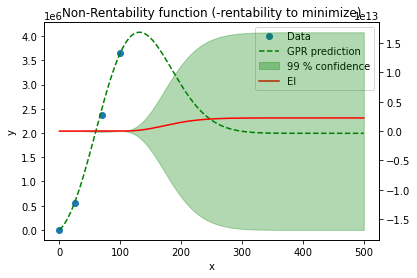

New value in :  [47.64176247]


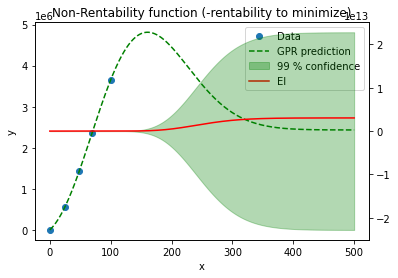

New value in :  [89.34290206]


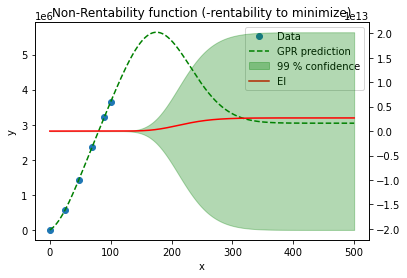

New value in :  [8.1457899]


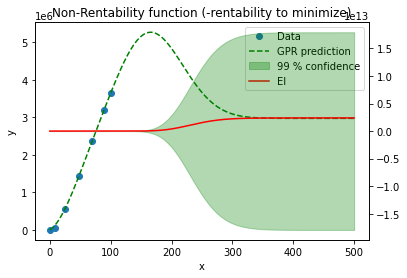

New value in :  [58.70204884]


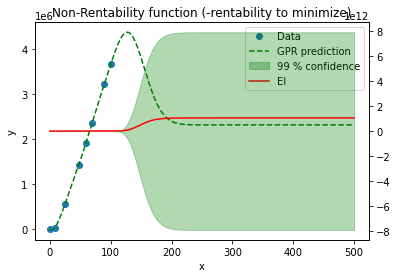

In [47]:
x_opt, y_opt, x_return, y_return = EGO(
    5, x_data, y_data, lambda x: -rentability(x), boundaries=(0, 100)
)

## Enlever la partie investissement et pertes
Et si on regardait simplement les gains pour voir ?

In [67]:
x_data = np.atleast_2d([0, 100, 1000]).T
y_data = [
    annual_cost(0),
    annual_cost(100),
    annual_cost(1000),
]
y_data = np.atleast_2d(y_data).T

New value in :  [569.18788504]


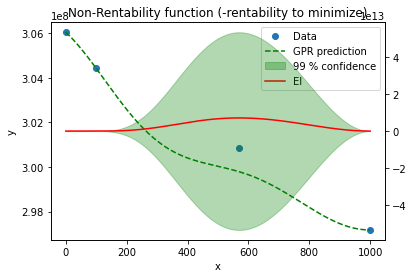

New value in :  [785.73846789]


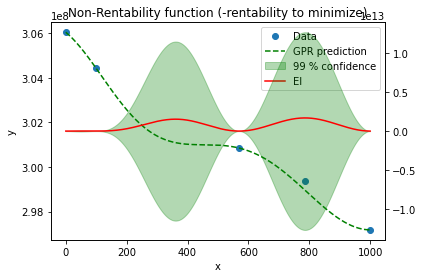

New value in :  [330.73829115]


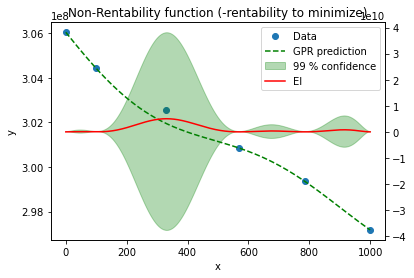

New value in :  [690.09096206]


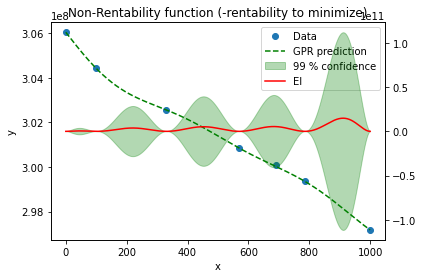

New value in :  [930.29053491]


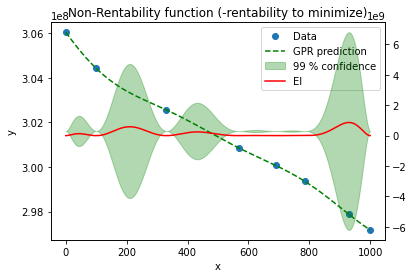

In [85]:
x_opt, y_opt, x_return, y_return = EGO(
    5, x_data, y_data, lambda x: annual_cost(x), boundaries=(0, 1000)
)

On peut en tirer le coefficient directeur de cette fonction presque linéaire !

In [83]:
y_out = np.sort(y_return, axis=0)
(y_out[-1] - y_out[0]) / 1000

array([8878.503518])

Il n'y a pas de critère d'arrêt intelligement défini ici, on s'arrête au bout de n boucles. On pourrait cependant mettre un arrêt sur les écarts entre les solutions x optimales, qui en convergeant vont se rapprocher. Mais ce n'est pas forcément un critère fiable, et ça ne l'ai pas dans notre cas puisque notre fonction n'est pas nécessairement continue en tout point (sans enlever les hypothèses de régularité du processus gaussien), et surtout on voit qu'elle diverge (en dehors de notre fenêtre de calcul).

Ici le Processus Gaussien n'a pas un grand intérêt car on constate directement une relation linéaire (mais qui n'était pas évidente a priori). Ceci nous permet d'estimer le prix de notre installation pour qu'elle soit rentable. Ainsi notre installation n'est rentable que si le prix de l'installation ne dépasse pas 8878€/MWh ! Soit bien moins que le prix de la batterie.

## Résultats

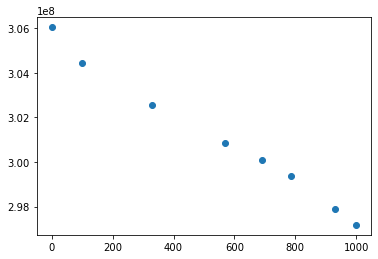

In [86]:
plt.plot(x_return, y_return, "o")

On estime le coût évité à 8878€/MWh/an peu importe la capacité totale installée !

## À Améliorer

Comme nous l'avons vu les fonctions que nous avons décrites sont encore grossières, c'est vraiment la méthode d'optimisation de la fonction black-box coûteuse par Processus Gaussien qui pourra être réutilisée. 

Le premier travail à réaliser sera autour de la fonction évaluant la rentabilité d'une installation, et notamment de toutes les valeurs numériques choisies (puissances, capacités, coûts).

C'est vraiment la pertinence de la fonction estimant la rentabilité qui va être importante, on pensera notamment à **évaluer la rentabilité sur différentes années** et situations météorologiques et non uniquement sur 2017 (on pourrait les générer avec un algorithme génétique), on pourra utiliser **les trois modes de stockage** envisagés pour élargir les possibilités d'installation (on fera donc une recherche mutlidimensionnelle avec les Processus Gaussiens), on prendra également en compte **les différences de puissance nominale entre ces trois modes** qui offrent des possibilités différentes. On note également que l'utilisation de ces installations durant les années simulées aura un impact sur les coûts de ces installations (OPEX).

Le second travail nécessaire serait une sélection de modèle sur l'a priori du Processus Gaussiens utilisé (en particulier le noyau), afin d'obtenir des premier résultats plus cohérents. Une recherche plus large (limite supérieure à 100MW) pourrait être envisagée. Cela sera primordial en 3D lorsque nous sortirons de cette visible relation linéaire.

